/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest R² Score: 0.9793
Random Forest MSE: 13.4911
Random Forest MAE: 2.6623


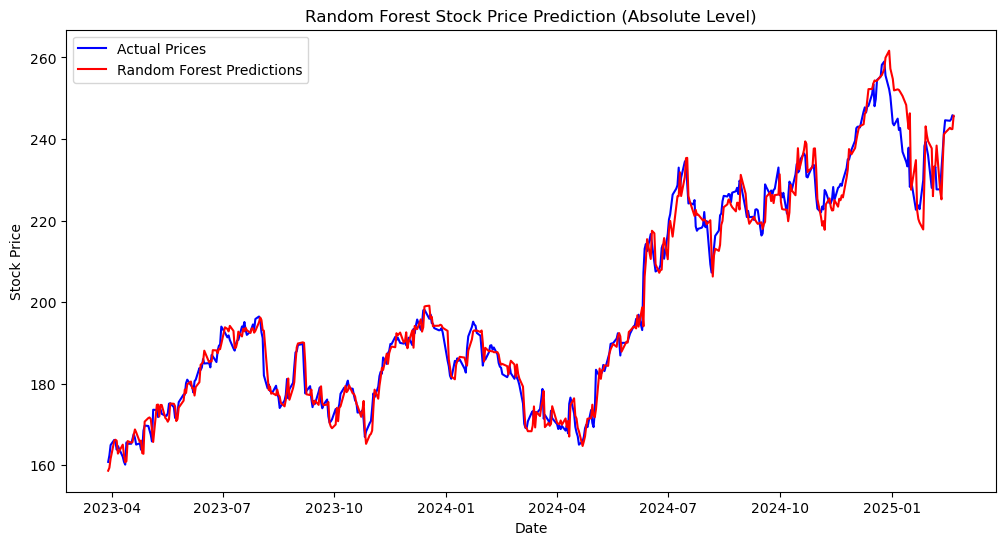

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the filtered 3-year dataset
df = pd.read_csv("AAPL_final_merged.csv")

# Ensure dates are in datetime format and sort the dataset
df["Date_x"] = pd.to_datetime(df["Date_x"])
df = df.sort_values("Date_x")

# Extract closing prices
closing_prices = df["close_x"].values.reshape(-1, 1)

# Normalize closing prices
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale between 0 and 1
closing_prices_scaled = scaler.fit_transform(closing_prices)

# Function to create time-series sequences for Random Forest
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length].flatten())  # Flatten for Random Forest
        y.append(data[i + seq_length])  # Predict next day's price
    return np.array(X), np.array(y)

# Define sequence length (past days used for prediction)
sequence_length = 30  # Using past 30 days to predict next day's closing price

# Create dataset for Random Forest
X_rf, y_rf = create_sequences(closing_prices_scaled, sequence_length)

# Split into training (80%) and testing (20%) sets
train_size = int(len(X_rf) * 0.8)
X_train_rf, X_test_rf = X_rf[:train_size], X_rf[train_size:]
y_train_rf, y_test_rf = y_rf[:train_size], y_rf[train_size:]

# Initialize and train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Make predictions
y_pred_rf = rf_model.predict(X_test_rf)

# Inverse transform predictions and actual values back to original scale
y_pred_rf_actual = scaler.inverse_transform(y_pred_rf.reshape(-1, 1))
y_test_rf_actual = scaler.inverse_transform(y_test_rf.reshape(-1, 1))

# Compute evaluation metrics
rf_r2 = r2_score(y_test_rf_actual, y_pred_rf_actual)
rf_mse = mean_squared_error(y_test_rf_actual, y_pred_rf_actual)
rf_mae = mean_absolute_error(y_test_rf_actual, y_pred_rf_actual)

# Display results
print(f"Random Forest R² Score: {rf_r2:.4f}")
print(f"Random Forest MSE: {rf_mse:.4f}")
print(f"Random Forest MAE: {rf_mae:.4f}")

# Plot actual vs predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(df["Date_x"][train_size + sequence_length:], y_test_rf_actual, label="Actual Prices", color="blue")
plt.plot(df["Date_x"][train_size + sequence_length:], y_pred_rf_actual, label="Random Forest Predictions", color="red")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Random Forest Stock Price Prediction (Absolute Level)")
plt.legend()
plt.show()
